In [364]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pandas_datareader.data as web
from datetime import datetime

import pandas as pd

#import sys
#import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")
    
import warnings
warnings.filterwarnings("ignore")

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Load Raw Data

In [270]:
data = pd.read_excel('SSE07-18.xlsx')

data = data.rename(index = data['Date'])
data.drop(['Date'], axis=1, inplace = True)
data.head(5)

,Adj Close
2007-01-04,2715.718994
2007-01-05,2641.333984
2007-01-08,2707.198975
2007-01-09,2807.803955
2007-01-10,2825.575928


In [272]:
# log returns
lrets = np.log(data/data.shift(1)).dropna()
lrets.columns = ['return']
lrets.head()

,return
2007-01-05,-0.027773
2007-01-08,0.024630
2007-01-09,0.036488
2007-01-10,0.006310
2007-01-11,-0.019825


## Plot Time Series and return series

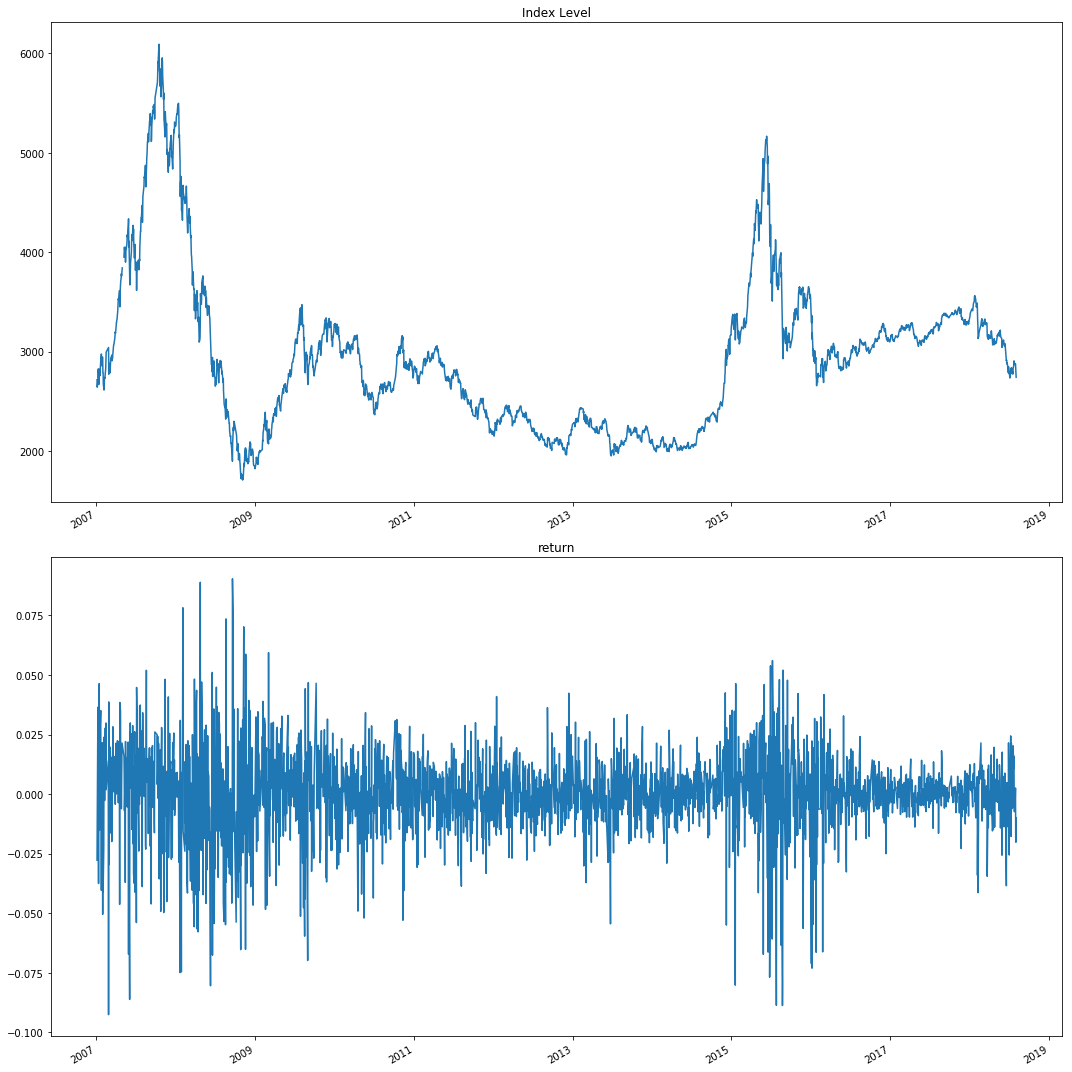

In [273]:
# plot time series
fig = plt.figure(figsize=(15,15))
#mpl.rcParams['font.family'] = 'Ubuntu Mono'
layout = (2, 1)
        
data_ax = plt.subplot2grid(layout, (0, 0))
data_return = plt.subplot2grid(layout, (1, 0))

        
data['Adj Close'].plot(ax=data_ax)
data_ax.set_title('Index Level')
lrets['return'].plot(ax=data_return)
data_return.set_title('return')

plt.subplots_adjust(top=0.92,bottom=0.08,left=0.10,right=0.95,hspace=0.25,wspace=0.35)
#plt.show()
plt.tight_layout()

## Plot ACF and PACF, Check normality for time series and return series

In [274]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        
        sm.qqplot(y, line='s', ax=qq_ax)
        
        qq_ax.set_title('QQ Plot')
        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

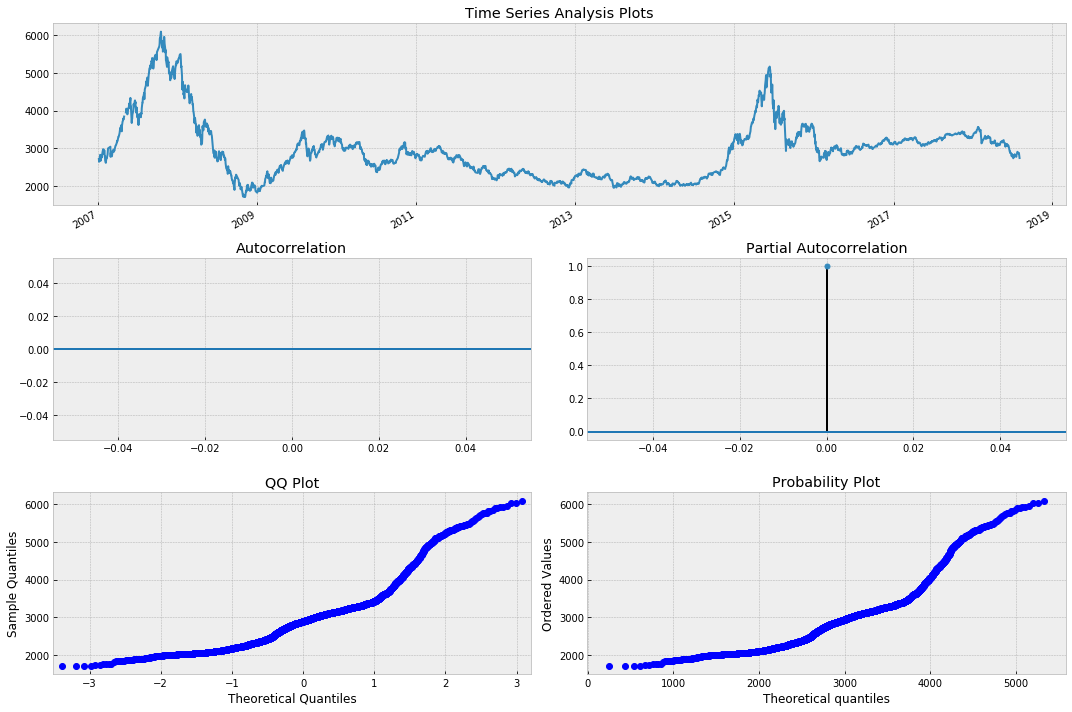

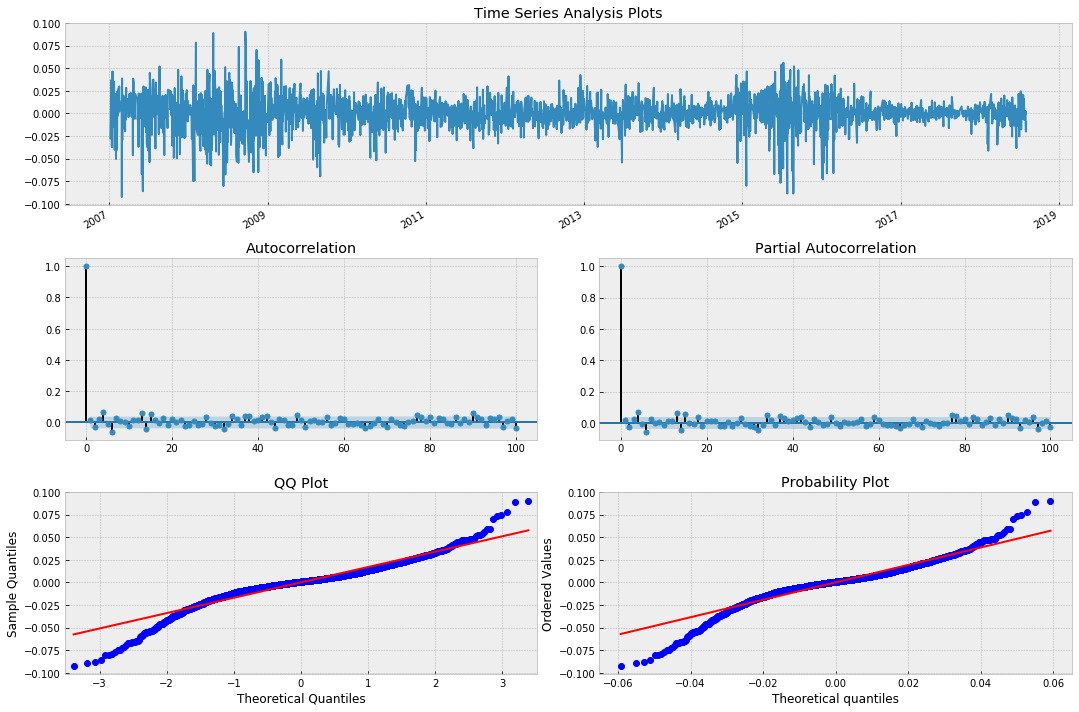

In [275]:
# price is more like a random walk
tsplot(data['Adj Close'], lags=100)
# Return is stationary
tsplot(lrets['return'], lags=100)

Obviously, price is more like random walk; return series is more or less stationary with ACF and PACF slightly lying out of the bound at multiple locations, showing characteristics of MA(p) and AR(q). Without differentiating betweeen ARMA and ARIMA, next let's try ARIMA on return series directly.

## ARIMA

aic: -14990.95491 | order: (5, 0, 4)


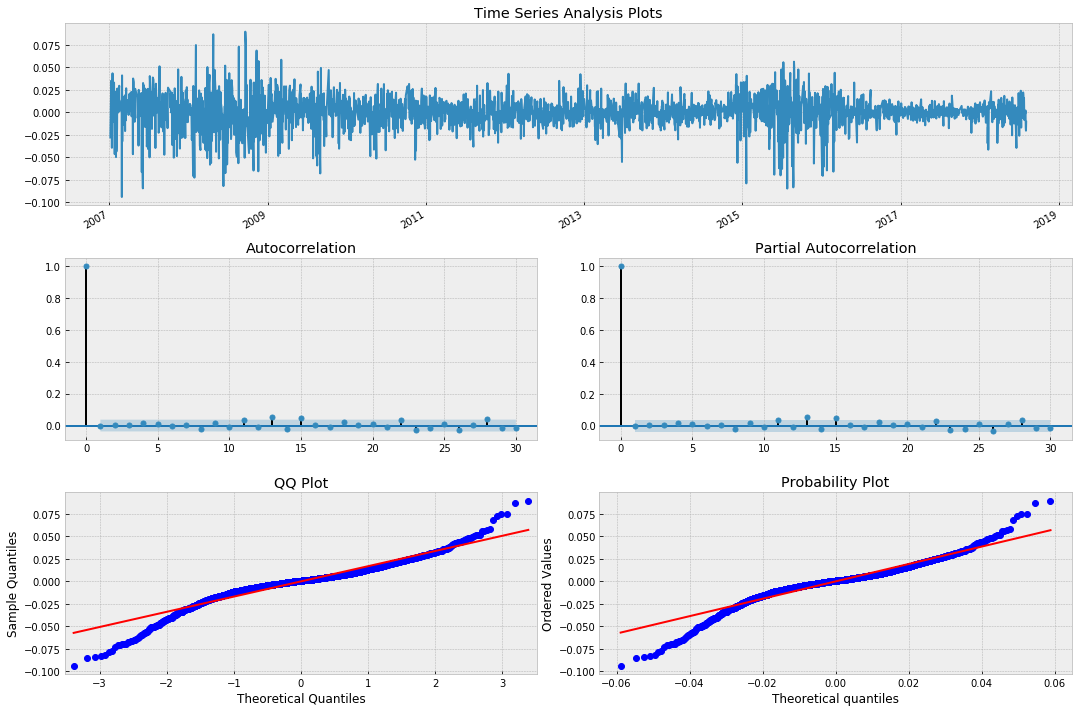

In [63]:
# Fit ARIMA(p, d, q) model to log returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(7) # [0,1,2,3,4,5,6]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets['return'], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

It should be no surprise that the best model has a differencing of 0. Recall that we already took the first difference of log prices to calculate the stock returns. The result is essentially identical to the ARMA(5, 4) model. The p value below is also larger than 0.05, which states that the residuals are independent at the 95% level and thus an ARMA(5,4) model provides a good model fit.

In [66]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([23.44020629]), array([0.26769976]))

Next let's check the square of the residues.

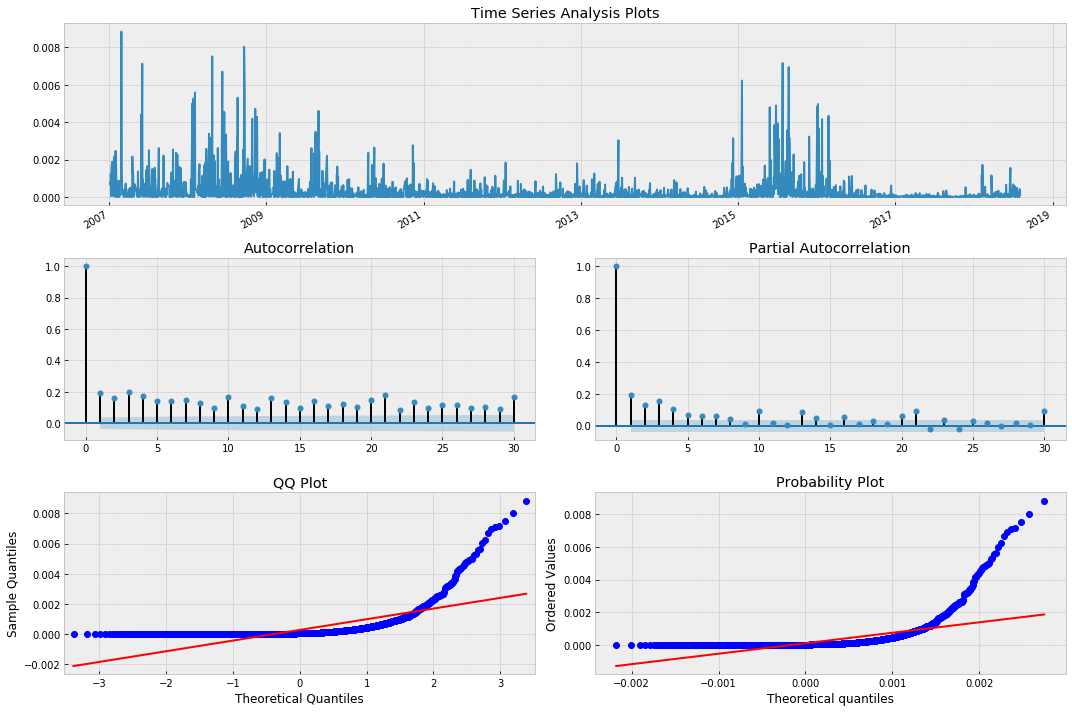

In [68]:
_ = tsplot((best_mdl.resid)**2, lags=30)

Notice the time series looks just like white noise. However, when we plot the square of the series, the ACF, and PACF seem to show significance at multiple lags. 

There is substantial evidence of a conditionally heteroskedastic process via the decay of successive lags. The significance of the lags in both the ACF and PACF indicate we need both AR and MA components for our model. Let's see if we can recover our process parameters using a GARCH model.

In [73]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package
from arch import arch_model

eps = best_mdl.resid
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7986.63052542509
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                7986.63
Distribution:                  Normal   AIC:                          -15965.3
Method:            Maximum Likelihood   BIC:                          -15941.5
                                        No. Observations:                 2819
Date:                Sun, Oct 07 2018   Df Residuals:                     2815
Time:                        01:06:53   Df Model:                            4
                                 Mean Model                             

/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


## Summary

In [276]:
def _get_best_model_aic(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(7) # [0,1,2,3,4,5,6]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

def _get_best_model_bic(TS):
    best_bic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(7) # [0,1,2,3,4,5,6]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_bic = tmp_mdl.bic
                    if tmp_bic < best_bic:
                        best_bic = tmp_bic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('bic: {:6.5f} | order: {}'.format(best_bic, best_order))                    
    return best_bic, best_order, best_mdl

In [278]:
res_tup_aic = _get_best_model_aic(lrets['return'])
res_tup_bic = _get_best_model_bic(lrets['return'])

aic: -14990.95491 | order: (5, 0, 4)
bic: -14957.51760 | order: (0, 0, 1)


In [287]:
order_aic = res_tup_aic[1]
ARIMA_model_aic = res_tup_aic[2]

order_bic = res_tup_bic[1]
ARIMA_model_bic = res_tup_bic[2]

In [288]:
#ARIMA_model_bic

In [289]:
import pickle
save_model = open("ARIMA_model_aic.pickle","wb")
pickle.dump(ARIMA_model_aic, save_model)
save_model.close()

import pickle
save_model = open("ARIMA_model_bic.pickle","wb")
pickle.dump(ARIMA_model_bic, save_model)
save_model.close()

In [290]:
open_model = open("ARIMA_model_aic.pickle", "rb")
ARIMA_model_aic = pickle.load(open_model)
open_model.close()

open_model = open("ARIMA_model_bic.pickle", "rb")
ARIMA_model_bic = pickle.load(open_model)
open_model.close()

Since we've already taken the log of returns, we should expect our integrated component d to equal zero, which it does. We find the best model is ARIMA(5,0,4).
Now we plot the residuals to decide if they possess evidence of conditional heteroskedastic behaviour

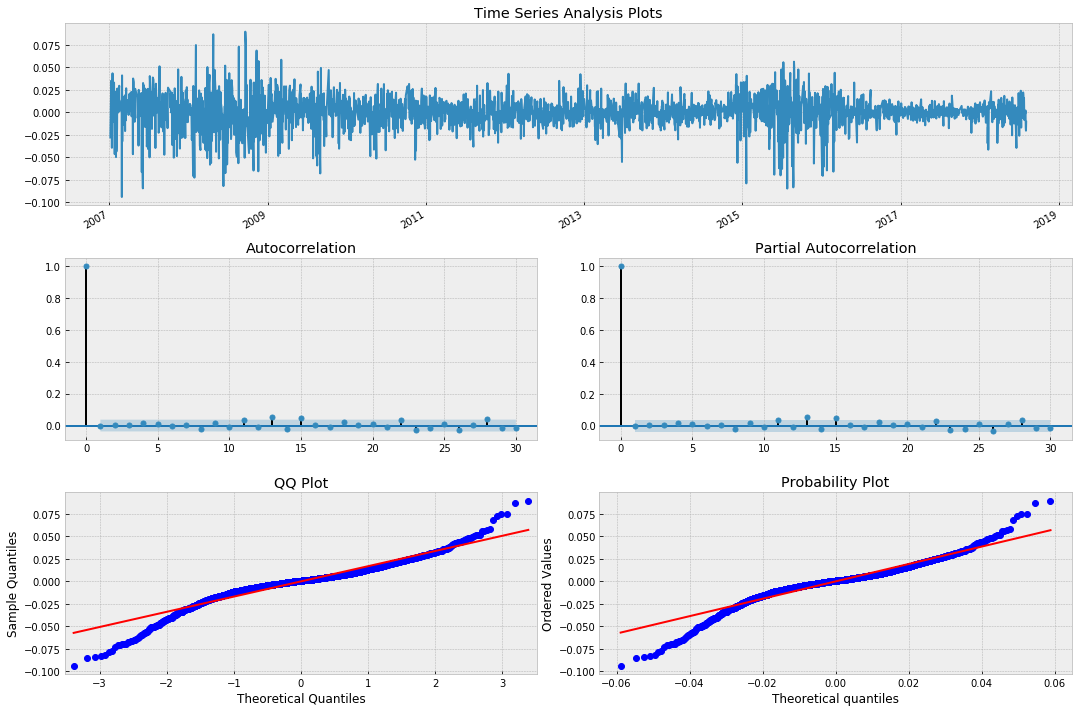

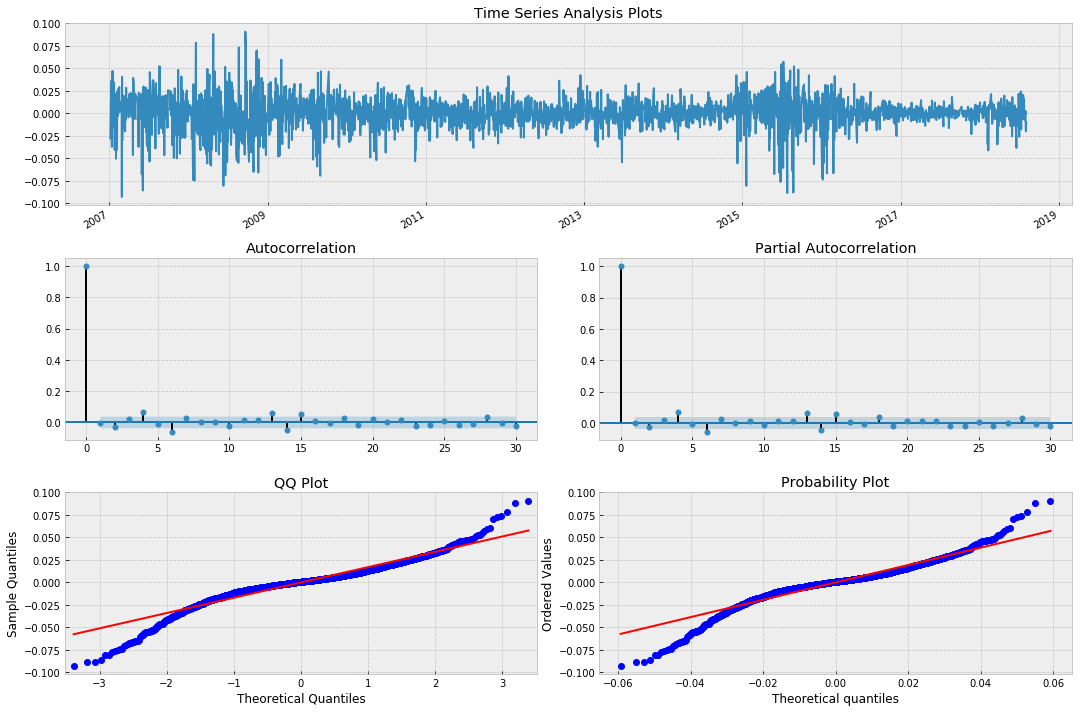

In [291]:
tsplot(ARIMA_model_aic.resid, lags=30)
tsplot(ARIMA_model_bic.resid, lags=30)

We find the reiduals look like white noise. Let's look at the square of residuals

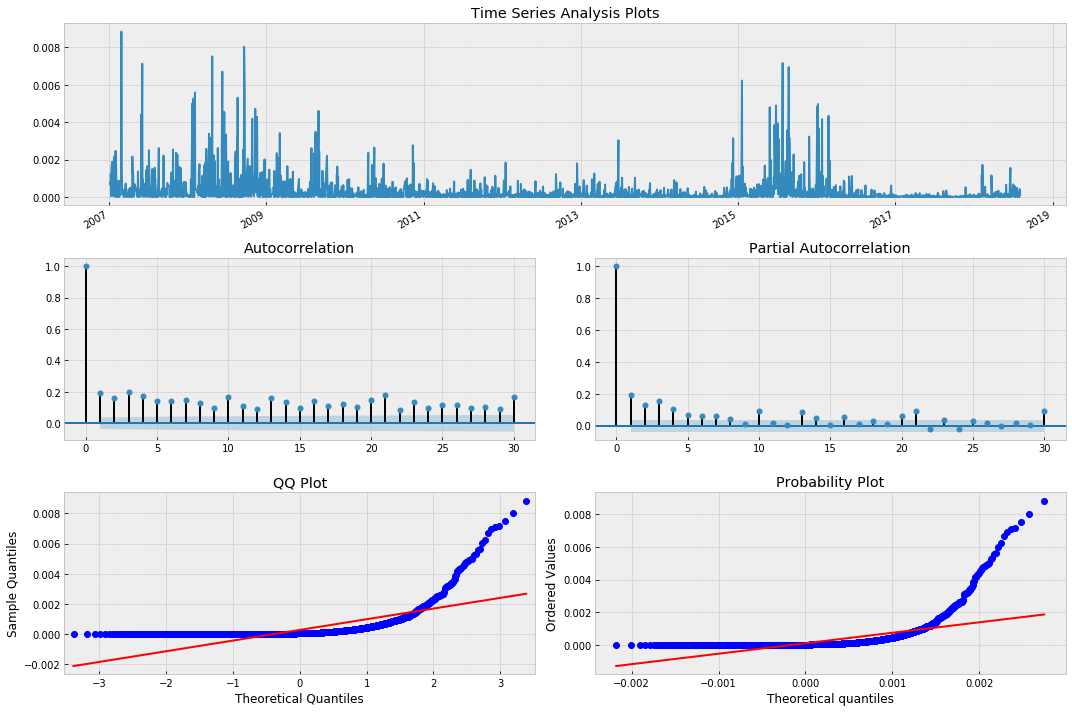

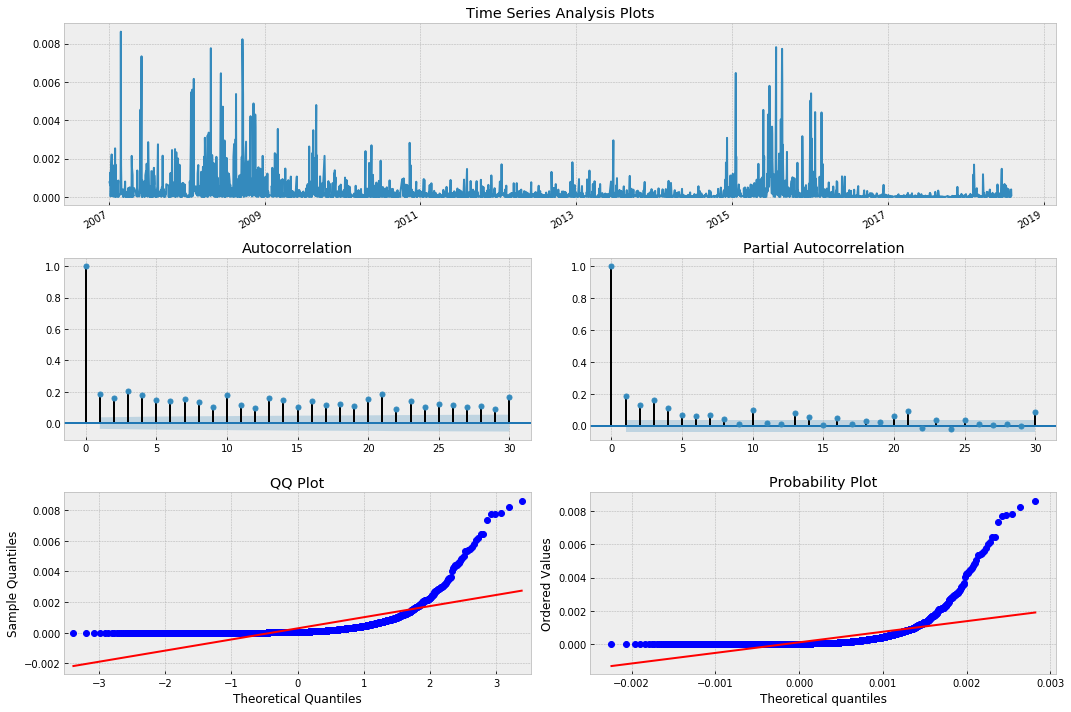

In [292]:
tsplot((ARIMA_model_aic.resid)**2, lags=30)
tsplot((ARIMA_model_bic.resid)**2, lags=30)

We can see clear evidence of autocorrelation in squared residuals. Let's fit a GARCH model and see how it does.

In [333]:
try:
    # Now we can fit the arch model using the best fit arima model parameters
    #p_aic = order_aic[0]
    #o_aic = order_aic[1]
    #q_aic = order_aic[2]
    # Using student T distribution usually provides better fit
    #am_aic = arch_model(ARIMA_model_aic.resid, p=p_aic, o=o_aic, q=q_aic, dist='StudentsT')
    am_aic = arch_model(ARIMA_model_aic.resid, p=5, o=0, q=10, dist='StudentsT')
    res_aic = am_aic.fit(update_freq=5, disp='off')
    print(res_aic.summary())
except:
    print("Doesn't work")

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                  -68883.015
Mean Model:                   Constant Mean   Adj. R-squared:             -68883.015
Vol Model:                            GARCH   Log-Likelihood:               -8360.98
Distribution:      Standardized Student's t   AIC:                           16758.0
Method:                  Maximum Likelihood   BIC:                           16864.9
                                              No. Observations:                 2819
Date:                      Sun, Oct 07 2018   Df Residuals:                     2801
Time:                              20:03:06   Df Model:                           18
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -4

/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [370]:
try:
    p_bic = order_bic[0]
    o_bic = order_bic[1]
    q_bic = order_bic[2]
    # Using student T distribution usually provides better fit
    am_bic = arch_model(ARIMA_model_bic.resid, p=p_bic, o=o_bic, q=q_bic, dist='StudentsT')
    res_bic = am_bic.fit(update_freq=5, disp='off')
    print(res_bic.summary())
except:
    print("Doesn't work")

Doesn't work


`BIC` doesn't work here. Let's focus on `AIC`.

Let's plot the residuals again.

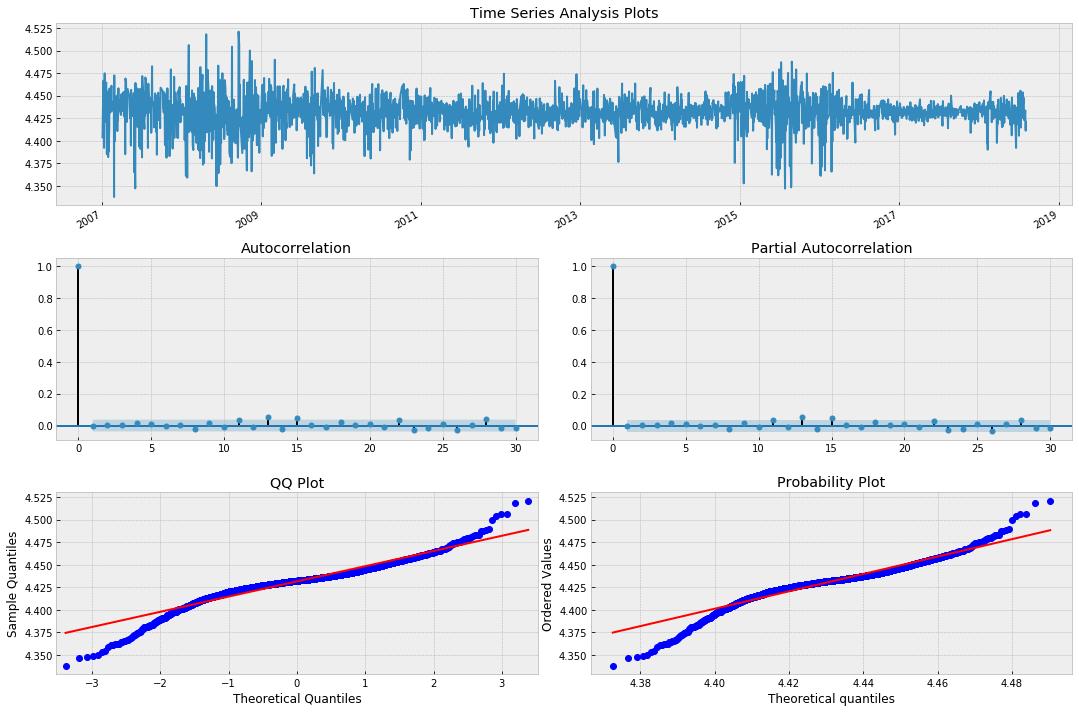

In [334]:
tsplot(res_aic.resid, lags=30)

The plots looks like a realisation of a discrete white noise process, indicating a good fit. Let's plot a square of residuals to be sure

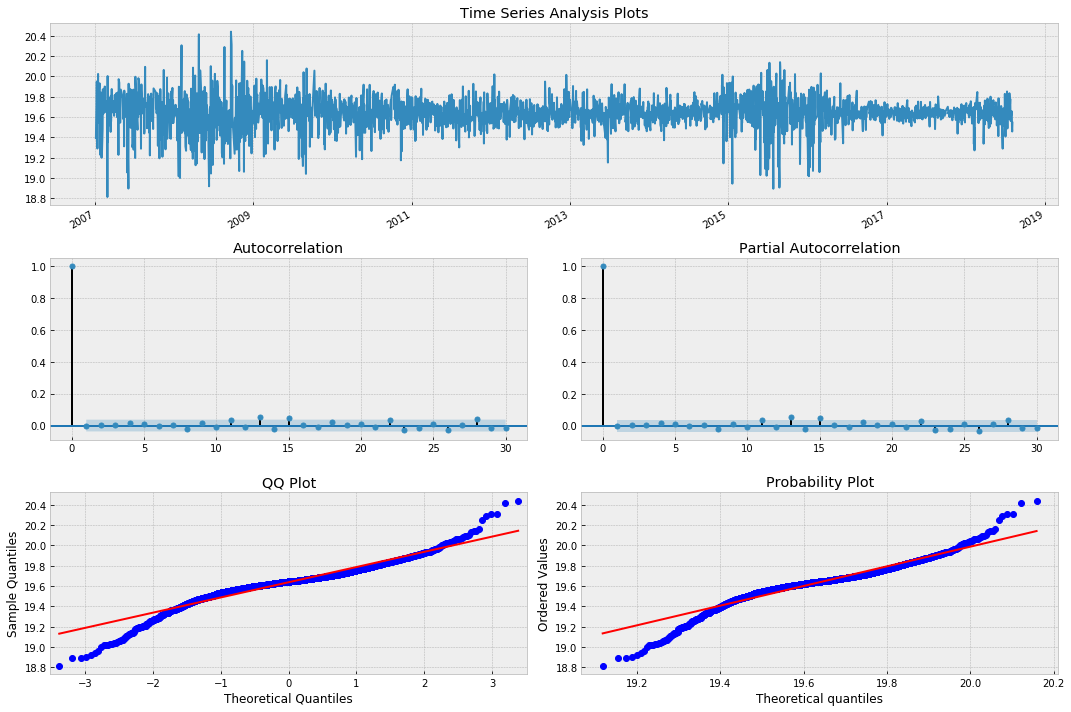

In [335]:
tsplot((res_aic.resid)**2, lags=30)

So the residue after ARIMA(5,0,4) fits the GARCH(5,10) model. Next let's do the backtesting with the GARCH model we've built.

## Forecast

At this stage we loop through the last 100 days in the time series and fit the ARIMA and GARCH model we've built to the rolling window of length $k=10$.

In [357]:
leng = len(lrets['return'])

In [372]:
windowLength = 20
foreLength = 100

In [373]:
signal = 0*lrets[-foreLength:]
for d in range(foreLength):
    #print(d)
    # create a rolling window by selecting the values between 1+d and k+d of S&P500 returns
    #TS = lrets[(leng+d):(leng+windowLength+d)] 
    # Find the best ARIMA fit (we set differencing to 0 since we've already differenced the series once)
    #res_tup = _get_best_model_aic(TS)
    #order = res_tup[1]
    #model = res_tup[2]
    #now that we have our ARIMA fit, we feed this to GARCH model
    #p_ = order[0]
    #o_ = order[1]
    #q_ = order[2]
    am = arch_model(ARIMA_model_aic.resid[(leng-foreLength+d):(leng-foreLength+windowLength+d)],
                    p=5, o=0, q=10, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    out = res.forecast(horizon=1, start=None, align='origin')
    #print(out.mean)
    signal.iloc[d] = out.mean['h.1'].iloc[-1]

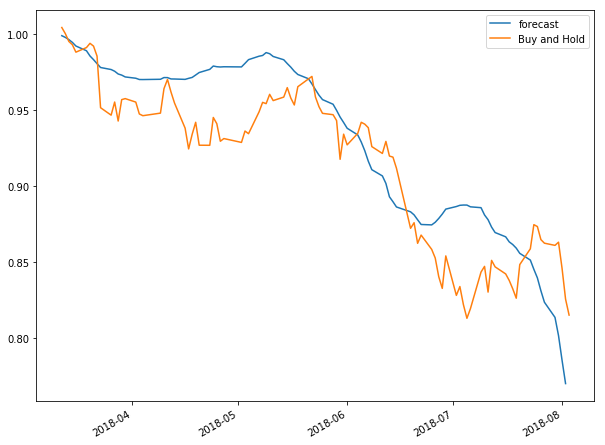

In [374]:
rets = pd.DataFrame(index = signal.index, columns=['Buy and Hold', 'forecast'])
rets['Buy and Hold'] = ARIMA_model_aic.resid[-foreLength:]
rets['forecast'] = signal
#rets['forecast'] = rets['forecast']*rets['Buy and Hold']
eqCurves = pd.DataFrame()
eqCurves['Buy and Hold']=rets['Buy and Hold'].cumsum()+1
eqCurves['forecast'] = rets['forecast'].cumsum()+1
eqCurves['forecast'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()

## Conclusion:

**To sum up:**
* After fitting the ARIMA(5,0,4) model, we have residue series `ARIMA_model_aic.resid`.
* Then we fit GARCH(5,0,10) to `ARIMA_model_aic.resid`.
* The above picture shows that the forecast residue series obtained from GARCH(5,0,10) fit well to the true `ARIMA_model_aic.resid`.

**Thus, we conclude that:**
* The return series of the stock index fits the model `ARIMA(5,0,4)`.
* The residue of `ARIMA(5,0,4)` fits the model `GARCH(5,0,10)`.